In [1]:
import pandas as p
import numpy as np
import matplotlib.pyplot as plt
import seaborn as s
import warnings
warnings.filterwarnings('ignore')

import datetime as dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

plt.rcParams['figure.figsize'] = [15,8]

In [5]:
df = p.read_csv('train.csv')
df_test = p.read_csv('test.csv')
df.shape

(27482, 17)

In [3]:
y = df.Price

In [5]:
dtype_info = p.DataFrame()
dtype_info['Unique'] = df_merge.nunique()
dtype_info['DType'] = df_merge.dtypes
dtype_info

,Unique,DType
Levy,635,object
Manufacturer,68,object
Model,1981,object
Prod. year,59,int64
Category,11,object
Leather interior,2,object
Fuel type,7,object
Engine volume,112,object
Mileage,9977,object
Cylinders,16,float64


# Data Cleaning


##### Converting Mileage to Floating Values AND replacing '0's with mean values of Mileage Column

In [6]:
#Conversion Part
#df_merge.Mileage = df.Mileage.apply(lambda x: float(int(x.split()[0]))/1000)
df_merge['Mileage'] = p.to_numeric(df_merge.Mileage.str.split(' ').str[0], downcast='float')
#Mean Part
df_merge['Mileage'] = np.where(df_merge['Mileage'] == 0.0,df_merge['Mileage'].mean(),df_merge['Mileage'])

#### Fixing Doors

In [7]:
df_merge['Doors'].unique()
df_merge.Doors = np.where((df_merge.Doors == '04-May') | (df_merge.Doors == '02-Mar'), df_merge.Doors.str.split('-').str[0],df_merge.Doors)

#### Taking Care of '-'s And Replacing With Mean

In [8]:
#Replacing hyphens with 0s
def replaceHyphen(n):
    if n == '-':
        return 0.0
    return float(n)
df_merge.Levy = df_merge.Levy.apply(lambda x: replaceHyphen(x))

#Replacing 0s mean of levy vals
levy_mean = int(df_merge.Levy.mean())
def replaceZeroLevy(n):
    if int(n) == 0:
        return levy_mean
    return n
df_merge.Levy = df_merge.Levy.apply(lambda x: replaceZeroLevy(x))

#### Splitting Turbo and Non Turbo Classes

In [9]:
#Getting raw number 
def convToVol(n):
    n = str(n).strip()
    tokens = n.split()
    return float(tokens[0])
#Splitting Turbo and non turbo engine types
def TurboClass(n):
    n = str(n).strip()
    tokens = n.split()
    if len(tokens) == 1:
        return 0
    else:
        return 1

df_merge['Turbo'] = df_merge['Engine volume'].apply(lambda x: TurboClass(x))
df['Engine volume'] = df['Engine volume'].apply(lambda x: convToVol(x))
df_merge['Turbo'].sum()

2759

In [10]:
current = dt.datetime.now()
df_merge['Prod. year'] = current.year - df_merge['Prod. year']

<AxesSubplot:>

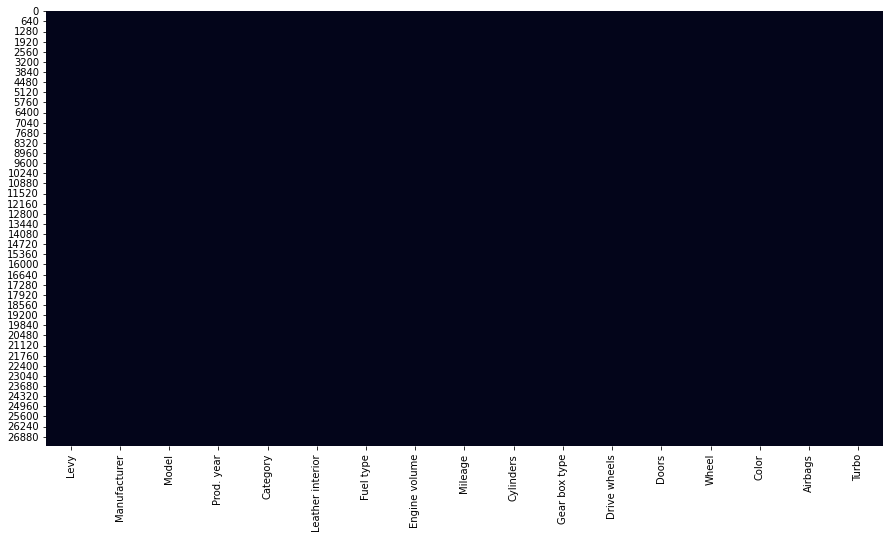

In [11]:
s.heatmap(df_merge.isnull(), cbar=False)


<AxesSubplot:>

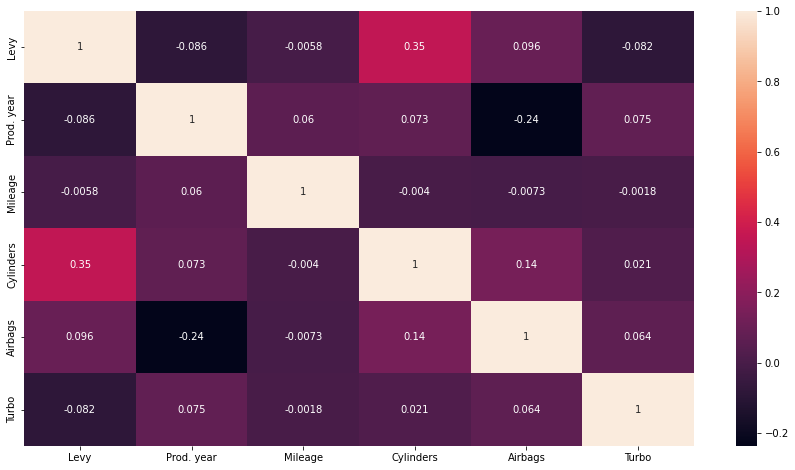

In [12]:
s.heatmap(df_merge.corr(), cbar=True, annot=True)

#### Checking For Skewness


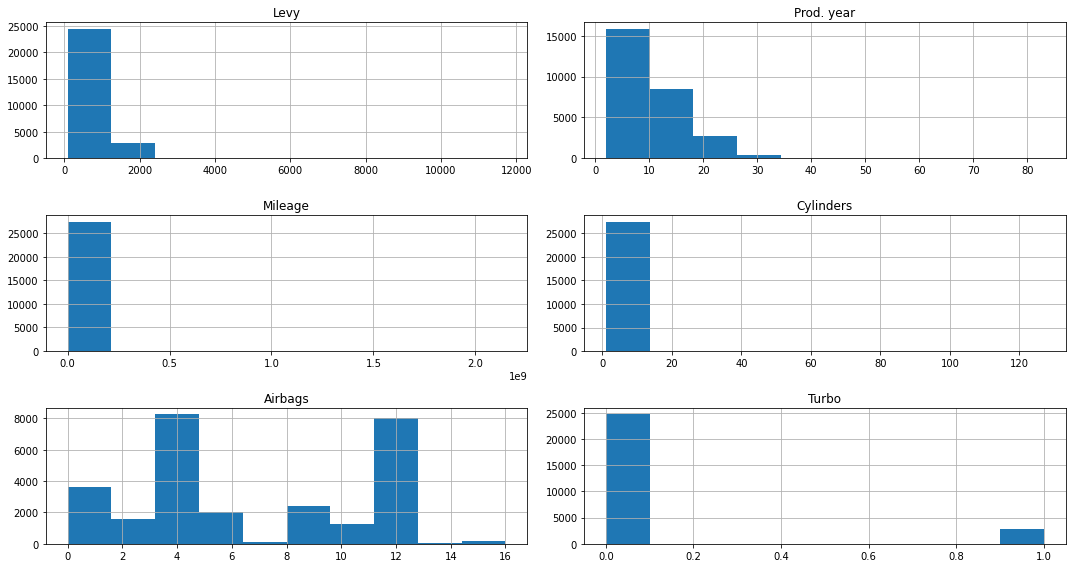

In [13]:
df_merge.hist()
plt.tight_layout()

In [14]:
from scipy.stats import shapiro
skewness = shapiro(y)
if skewness[1] <= 0:
    print('neg skewed')
else:
    print('pos skewed')

neg skewed


In [15]:
y = np.log(y)

## Building Model

#### Splitting Categorical and Numeric Data

In [16]:
categ_var = df_merge.select_dtypes(include='object')
numeric_var = df_merge.select_dtypes(include=np.number)

#### Dummies for Categorical Variables And Creating Final Data With It

In [17]:
categ_dummies = p.get_dummies(categ_var, drop_first=True)

In [18]:
df_f = p.concat([numeric_var, categ_dummies], axis='columns')

In [19]:
data_train = df_f.iloc[:19237]
data_test = df_f.iloc[19237:]


In [20]:
X = df_f.iloc[:19237]
y = y

#### Train and Test Splitting

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=10)

In [22]:
#Randomized Search CV for searching the best parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [23]:
rf = RandomForestRegressor()

In [24]:
rf_random_model = RandomizedSearchCV(estimator = rf,
                                     param_distributions = random_grid,
                                    scoring='neg_mean_squared_error',
                                    n_iter = 10,
                                    cv = 5,
                                    verbose=2,
                                    random_state=42,
                                    n_jobs = 1)
                                    

In [25]:
rf_random_model.fit(Xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  17.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  15.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  13.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  13.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  13.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=  28.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=  28.8s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [26]:
import pickle
filename = 'beta_Nmodel_0_0_2.sav'
'''
0.0.1 With ID
0.0.2 Without 'ID' column
'''
pickle. dump(rf_random_model, open(filename, 'wb'))

In [27]:
rf_random_model.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [28]:
reg= ExtraTreesRegressor()
reg.fit(Xtrain,ytrain)
ExtraTreesRegressor()

ExtraTreesRegressor()

In [29]:
#finding important features
feat_importances = p.Series(reg.feature_importances_, index=Xtrain.columns)

In [30]:
p.DataFrame(feat_importances.nlargest(30)).index


Index(['Airbags', 'Mileage', 'Prod. year', 'Gear box type_Tiptronic',
       'Leather interior_Yes', 'Levy', 'Manufacturer_HYUNDAI', 'Turbo',
       'Fuel type_Hybrid', 'Color_Black', 'Color_White', 'Drive wheels_Front',
       'Color_Grey', 'Fuel type_Diesel', 'Wheel_Right-hand drive',
       'Color_Silver', 'Cylinders', 'Model_FIT', 'Gear box type_Variator',
       'Category_Sedan', 'Category_Jeep', 'Engine volume_2.4',
       'Manufacturer_SSANGYONG', 'Manufacturer_TOYOTA', 'Fuel type_Petrol',
       'Drive wheels_Rear', 'Color_Blue', 'Category_Hatchback',
       'Engine volume_1.5', 'Model_Prius'],
      dtype='object')

In [31]:
#instantiating the randomforest regressor using the best parameters
mod4 = RandomForestRegressor(n_estimators= 1000, max_depth= 25,
 max_features= 'sqrt',
 min_samples_leaf=1,
 min_samples_split = 2
 )

In [32]:
X1 = data_train[['Airbags', 'Mileage', 'Prod. year',  'Gear box type_Tiptronic',
       'Leather interior_Yes', 'Levy', 'Manufacturer_HYUNDAI', 'Turbo',
       'Fuel type_Hybrid', 'Fuel type_Diesel', 'Color_White',
       'Drive wheels_Front', 'Color_Black', 'Wheel_Right-hand drive',
       'Color_Grey', 'Color_Silver', 'Cylinders', 'Model_FIT',
       'Manufacturer_SSANGYONG', 'Engine volume_2.4', 'Category_Jeep',
       'Gear box type_Variator', 'Category_Sedan', 'Manufacturer_TOYOTA',
       'Fuel type_Petrol', 'Color_Blue', 'Drive wheels_Rear', 'Model_Prius',
       'Category_Hatchback']]
y1=y

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=0.3, random_state=10)

In [33]:
model = mod4.fit(X1_train, y1_train)

In [34]:
y_predict=model.predict(X1_test)

In [35]:
#calculating the RMLSE score
from sklearn.metrics import mean_squared_log_error
RMLSE=np.sqrt(mean_squared_log_error(np.exp(y1_test),np.exp(y_predict)))

In [36]:
RMLSE

0.9126030775711896

In [37]:
import pickle
filename = 'beta_Rmodel_0_0_1.sav'
model = pickle.load(open(filename, 'rb'))

In [41]:
y_pred_R = model.predict(Xtest.drop('id', axis= 1))

KeyError: "['id'] not found in axis"

In [ ]:
from sklearn.metrics import mean_squared_log_error
RMLSE=np.sqrt(mean_squared_log_error(np.exp(ytest),np.exp(y_pred_R)))
mean_squared_log_error()
RMLSE

TypeError: mean_squared_log_error() missing 2 required positional arguments: 'y_true' and 'y_pred'

In [ ]:
from sklearn import metrics
metrics.mean_absolute_error(ytest, y_pred_R)


0.5025113847789983

In [ ]:
from sklearn.metrics import r2_score
r2_score(ytest, y_pred_R)

0.666462468574758

In [ ]:
np.exp(y)

0        13328.0
1        16621.0
2         8467.0
3         3607.0
4        11726.0
          ...   
19232     8467.0
19233    15681.0
19234    26108.0
19235     5331.0
19236      470.0
Name: Price, Length: 19237, dtype: float64

In [ ]:
y.info

<bound method Series.info of 0         9.497622
1         9.718422
2         9.043932
3         8.190632
4         9.369564
           ...    
19232     9.043932
19233     9.660205
19234    10.169997
19235     8.581294
19236     6.152733
Name: Price, Length: 19237, dtype: float64>

In [ ]:
np.exp(y).describe()

count    1.923700e+04
mean     1.855593e+04
std      1.905813e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.207500e+04
max      2.630750e+07
Name: Price, dtype: float64